Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import keras.backend as K
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc,roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Activation
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Input data

In [2]:
# Generate data
# Generate data
train_dir='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/train/'
test_dir='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/test/'
class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,
                                rotation_range=5,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                #zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

train_dataset=train_datagen.flow_from_directory(directory='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/train/',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)

valid_dataset=valid_datagen.flow_from_directory(directory='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/test/',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               batch_size=64)

test_dataset=test_datagen.flow_from_directory(directory='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/test/',
                                             target_size=(48,48),
                                             batch_size=64,
                                             class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Building model

In [3]:
model_2=ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [4]:
# Freezing layers

for layer in model_2.layers[:4]:
    layer.trainable=False

# Building model
model_resnet=Sequential()
model_resnet.add(model_2)
model_resnet.add(Dropout(0.5))
model_resnet.add(Flatten())
model_resnet.add(BatchNormalization())
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,kernel_initializer='he_uniform'))
model_resnet.add(BatchNormalization())
model_resnet.add(Activation('relu'))
model_resnet.add(Dense(7,activation='softmax'))

In [5]:
# Model summary
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [6]:

# Training
check_point=ModelCheckpoint('resnet_model.h5')
model_resnet.compile(optimizer='Adam',loss='categorical_crossentropy',metrics='accuracy')
history_resnet=model_resnet.fit(train_dataset,validation_data=valid_dataset,epochs=60,verbose=1,callbacks=[check_point])


Epoch 1/60


359/359 [==============================] - ETA: 0s - loss: 1.9392 - accuracy: 0.2200

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 370s 991ms/step - loss: 1.9392 - accuracy: 0.2200 - val_loss: 1.8341 - val_accuracy: 0.2471
Epoch 2/60
359/359 [==============================] - 362s 1s/step - loss: 1.8489 - accuracy: 0.2451 - val_loss: 1.8166 - val_accuracy: 0.2471
Epoch 3/60
359/359 [==============================] - 360s 1s/step - loss: 1.8247 - accuracy: 0.2473 - val_loss: 2.8182 - val_accuracy: 0.1716
Epoch 4/60
359/359 [==============================] - 361s 1s/step - loss: 1.8219 - accuracy: 0.2469 - val_loss: 50.7439 - val_accuracy: 0.1335
Epoch 5/60
359/359 [==============================] - 360s 1s/step - loss: 1.8210 - accuracy: 0.2478 - val_loss: 1.9838 - val_accuracy: 0.1704
Epoch 6/60
359/359 [==============================] - 361s 1s/step - loss: 1.8169 - accuracy: 0.2497 - val_loss: 3.3706 - val_accuracy: 0.1737
Epoch 7/60
359/359 [==============================] - 360s 1s/step - loss: 1.8150 - accuracy: 0.2482 - val_loss: 1.8163 - val_accuracy: 0.2471
Epoch 

In [7]:
# Save model
model_resnet.save('resnet_model.h5')

Evaluation

In [8]:
# Evaluating
resnet_acc=model_resnet.evaluate(test_dataset,verbose=0)[1]
preds=model_resnet.predict(test_dataset)
y_preds=np.argmax(preds,axis=1)
y_test=np.array(test_dataset.labels)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

113/113 [==============================] - 30s 255ms/step
Accuracy: 0.11577040958484257
Precision: 0.01340278773544221
Recall: 0.11577040958484257
F1 Score: 0.02402427528155929


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


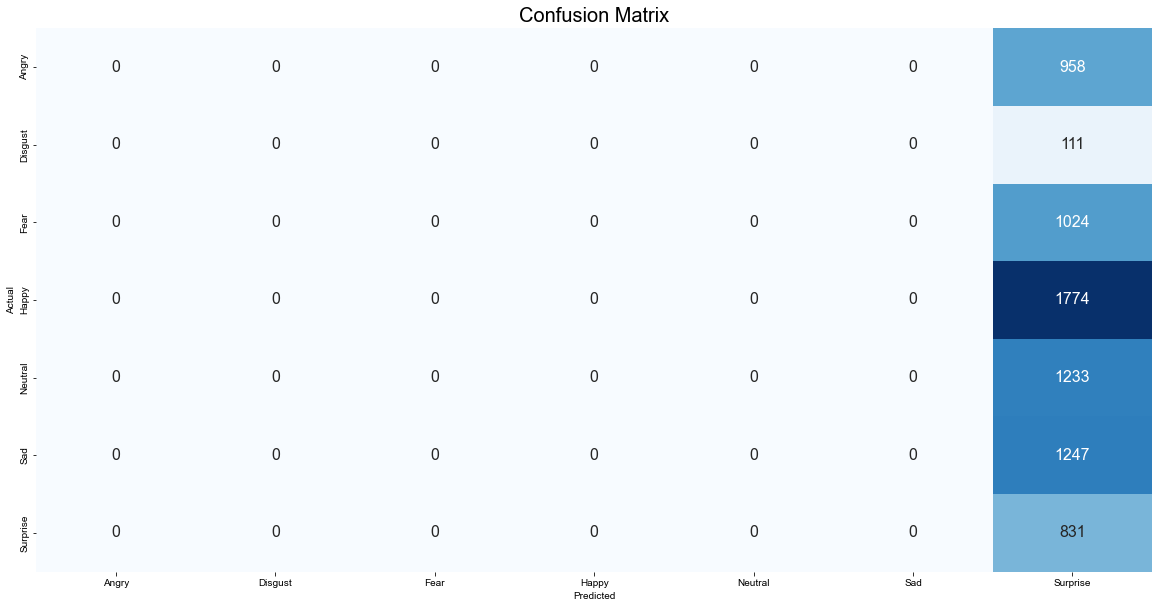

In [9]:
# Confution matrix
cm_data_resnet=confusion_matrix(y_test,y_preds)
cm_resnet=pd.DataFrame(cm_data_resnet,columns=class_labels,index=class_labels)
cm_resnet.index.name="Actual"
cm_resnet.columns.name="Predicted"
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
sn.set(font_scale=1.2)
ax_resnet=sn.heatmap(cm_resnet,cbar=False,cmap="Blues",annot=True,annot_kws={"size":16},fmt='g')

In [10]:
# Classification report
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.00      0.00      0.00      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.12      1.00      0.21       831

    accuracy                           0.12      7178
   macro avg       0.02      0.14      0.03      7178
weighted avg       0.01      0.12      0.02      7178



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

ROC AUC score: 0.5054526089399973


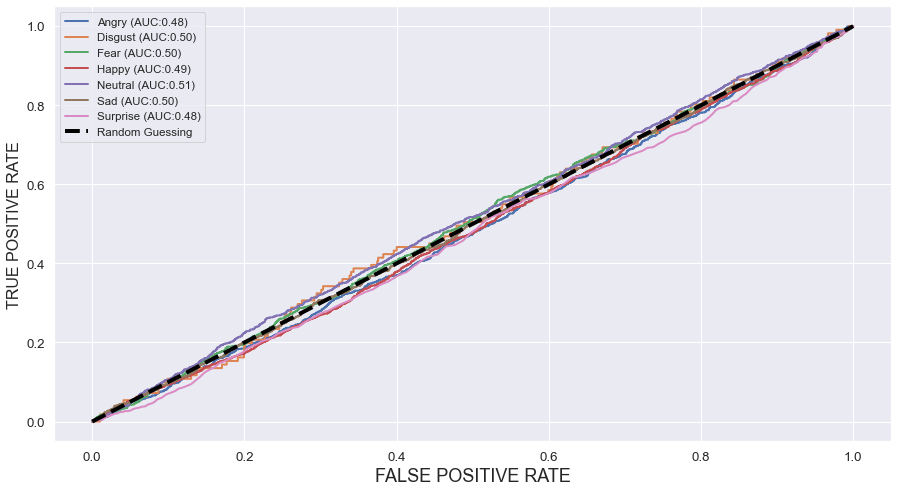

In [11]:
# Multiclass ROC curve
fig,c_ax=plt.subplots(1,1,figsize=(15,8))

def multiclass_roc_auc_score1(y_test,y_preds,average="macro"):
    lb=LabelBinarizer()
    lb.fit(y_test)
    y_test=lb.transform(y_test)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test[:,idx].astype(int),y_preds[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test,y_preds,average=average)

print('ROC AUC score:',multiclass_roc_auc_score1(y_test,preds,average='micro'))
plt.xlabel('FALSE POSITIVE RATE',fontsize=18)
plt.ylabel('TRUE POSITIVE RATE',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

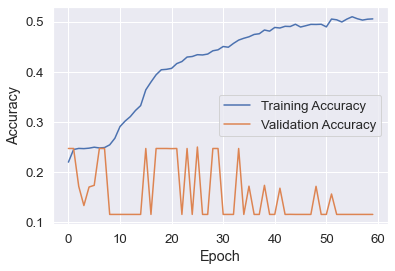

In [12]:
# Plotting result
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()